In [31]:
import torch

In [34]:
adv_images = torch.randn(size=(1,4,4))

In [39]:
eps = torch.tensor(0.5)

In [40]:
adv_images = torch.minimum(torch.maximum(-eps, adv_images), eps) + adv_images

In [41]:
adv_images

tensor([[[-1.2082, -2.3241,  0.0600, -1.4320],
         [-0.3944, -0.5565, -0.0814, -0.8059],
         [ 0.7397,  0.9991,  0.5645,  1.2103],
         [ 0.0350,  1.3005,  0.6355, -0.9752]]])

In [29]:
eps = torch.tensor(0.4)

In [30]:
adv_images = torch.minimum(torch.maximum(-eps, adv_images), eps)

tensor([[[-0.4000, -0.4000,  0.2098, -0.4000],
         [-0.3443, -0.4000, -0.4000, -0.4000],
         [ 0.3530,  0.4000,  0.4000,  0.4000],
         [-0.4000, -0.4000, -0.2821, -0.4000]]])

TypeError: min() received an invalid combination of arguments - got (int, int), but expected one of:
 * (Tensor input, *, Tensor out)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)


In [14]:
x = torch.randn(size=(1,32)) > 1

In [19]:
x

tensor([[False, False, False, False,  True, False, False, False, False, False,
         False,  True, False,  True, False, False, False,  True, False, False,
         False, False,  True, False, False, False, False, False, False, False,
         False, False]])

In [18]:
torch.sum(x)

tensor(5)

In [12]:
torch.where(x==1)[1].shape[0] / x.shape[1]

0.21875

In [1]:
import sys
sys.path.append("/home/zsarwar/Projects/SparseDNNs/scripts")

In [2]:
import torch
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision.models import resnet18

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import pickle
import torch
import os
import copy
import torch.nn as nn
import seaborn as sns
from torch.utils.data import DataLoader
from utils.dataset import CustomImageDataset, CustomImageDataset_Adv
from torchvision.transforms import transforms

/home/zsarwar/.conda/envs/cnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
adv_dataset_path = "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f_arch/MT_Baseline_814e4c261078e7110bf94f724cd2187e/Adversarial_Datasets/CW_adv_samples_2500_test_detector-type-Regular_integrated-False_c-1.0_d-0.0_eps-0.034.pickle"

with open(adv_dataset_path, 'rb') as adv_set:
    adv_samples = pickle.load(adv_set)



transform_adv = transforms.Compose([
    ])
valset = CustomImageDataset_Adv(adv_samples, transform=transform_adv)

val_loader = torch.utils.data.DataLoader(valset, batch_size=8,
                                            shuffle=False, num_workers=1)

In [4]:
class RandResNetFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        # Get a resnet18 backbone
        m = model
        return_nodes = {
            # node_name: user-specified key for output dict
            'x' : 'x',
            'conv1': 'conv1',
            'layer1.0.conv1': 'layer1.0.conv1',
            'layer1.0.conv2': 'layer1.0.conv2',
            'layer1.1.conv1': 'layer1.1.conv1',
            'layer1.1.conv2': 'layer1.1.conv2',
            'layer2.0.conv1': 'layer2.0.conv1',
            'layer2.0.conv2': 'layer2.0.conv2',
            'layer2.1.conv1': 'layer2.1.conv1',
            'layer2.1.conv2': 'layer2.1.conv2',
            'layer3.0.conv1': 'layer3.0.conv1',
            'layer3.0.conv2': 'layer3.0.conv2',
            'layer3.1.conv1': 'layer3.1.conv1',
            'layer3.1.conv2': 'layer3.1.conv2',
            'layer4.0.conv1': 'layer4.0.conv1',
            'layer4.0.conv2': 'layer4.0.conv2',
            'layer4.1.conv1': 'layer4.1.conv1',
            'layer4.1.conv2': 'layer4.1.conv2',
            'fc' : 'fc'
      
        }
        self.body = create_feature_extractor(
            m, return_nodes=return_nodes)
    def forward(self, x):
        x = self.body(x)
        return x



In [5]:

from utils.resnet_rand_tracer_1 import resnet18 as resnet18_1,  SparsifyKernelGroups as SparsifyKernelGroups_1 
sparseblock_1 = SparsifyKernelGroups_1

from utils.resnet_rand_tracer_2 import resnet18 as resnet18_2,  SparsifyKernelGroups as SparsifyKernelGroups_2
sparseblock_2 = SparsifyKernelGroups_2
scale_factor=2


In [6]:
model_1 = resnet18_1(sparsefilter=sparseblock_1,scale_factor=scale_factor)                
model_1.fc = nn.Linear(in_features=512, out_features=10, bias=True)

ckpt_path = "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f_arch/MT_Baseline_43528ed29912dd1a3825f30bea8e4ba8/Checkpoints/model_best.pth.tar"
loc = 'cpu'
checkpoint = torch.load(ckpt_path, map_location=loc)
model_1.load_state_dict(checkpoint['state_dict'])

#model_1 = RandResNetFeatureExtractor(model_1)


"""
model_2 = resnet18_2(sparsefilter=sparseblock_2,scale_factor=scale_factor)                
model_2.fc = nn.Linear(in_features=512, out_features=10, bias=True)

ckpt_path = "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f_arch/MT_Baseline_814e4c261078e7110bf94f724cd2187e/Checkpoints/model_best.pth.tar"
loc = 'cpu'
checkpoint = torch.load(ckpt_path, map_location=loc)
model_2.load_state_dict(checkpoint['state_dict'])

#model_2 = RandResNetFeatureExtractor(model_2)
"""

'\nmodel_2 = resnet18_2(sparsefilter=sparseblock_2,scale_factor=scale_factor)                \nmodel_2.fc = nn.Linear(in_features=512, out_features=10, bias=True)\n\nckpt_path = "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f_arch/MT_Baseline_814e4c261078e7110bf94f724cd2187e/Checkpoints/model_best.pth.tar"\nloc = \'cpu\'\ncheckpoint = torch.load(ckpt_path, map_location=loc)\nmodel_2.load_state_dict(checkpoint[\'state_dict\'])\n\n#model_2 = RandResNetFeatureExtractor(model_2)\n'

In [7]:
# Compare 2x model Kernel weights for each alternative kernel block
model_1.layer2[0].conv1.weight.shape

torch.Size([256, 64, 3, 3])

In [8]:
model_1.layer2[1].conv1.weight[0, 0, :, :]

tensor([[ 0.0557,  0.1402,  0.0448],
        [-0.0387,  0.0431,  0.0107],
        [-0.0216, -0.0208,  0.0133]], grad_fn=<SliceBackward0>)

In [9]:
model_1.layer2[1].conv1.weight[0, 1, :, :]

tensor([[-0.0252,  0.1184,  0.1506],
        [ 0.0077,  0.0382,  0.0126],
        [ 0.0128, -0.1362, -0.1342]], grad_fn=<SliceBackward0>)

In [8]:

from utils.resnet_rand import resnet18, SparsifyKernelGroups
sparseblock = SparsifyKernelGroups
scale_factor=2

In [9]:

model = resnet18(sparsefilter=sparseblock,scale_factor=scale_factor)                
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)

ckpt_path = "/net/scratch/zsarwar/SparseDNNs/MT_cifar10_randCNN_10_8d64c1903fcb2ff6173fe22979c3175f_arch/MT_Baseline_43528ed29912dd1a3825f30bea8e4ba8/Checkpoints/model_best.pth.tar"
loc = 'cpu'
#checkpoint = torch.load(ckpt_path, map_location=loc)
#model.load_state_dict(checkpoint['state_dict'])

#model_1 = RandResNetFeatureExtractor(model_1)


In [17]:
for name, param in model.named_parameters():
    


conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [30]:
model._modules['layer1'][0].conv1

Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [6]:
from torchvision.models import resnet18

class NoisyResNet18(nn.Module):
  def __init__(self, model, std=0.015):
    super(NoisyResNet18, self).__init__()
    self.model = model
    self.std = std  # Standard deviation for the Gaussian noise

  def forward(self, x):
    # Iterate over all modules in the ResNet
    noisy_weights = {}
    for name, param in self.model.named_parameters():
      # Check if the parameter requires gradient (learnable)
      if param.requires_grad:
        # Create a copy of the weight parameter
        clean_weight = param.data.clone()
        # Add Gaussian noise with mean 0 and std self.std
        noise = torch.randn(clean_weight.size()).to(device=param.device) * self.std
        # Create the noisy weight
        noisy_weight = clean_weight + noise
        # Store the noisy weight for this pass
        noisy_weights[name] = noisy_weight
    # Update the weights of the resnet with noisy copies
    for name, weight in noisy_weights.items():
        self.resnet._modules[name].weight.data = weight.detach()
        if 'conv' in name:
            n = name.replace(".weight", "")
            self.model._modules[n].weight.data = weight
    # Forward pass through the modified ResNet
    output = self.model(x)
    # Restore original weights (optional)
    for name, param in self.model.named_parameters():
      if param.requires_grad:
        param.data = param.data.clone()  # Restore original weight
    return output

In [161]:
model = resnet18()

In [183]:
# Save original weights in dict and then perturb them
std = 0.015
og_weights = {}
for idx, (name, param) in enumerate(model.named_parameters()):
    if param.requires_grad and "conv" in name:
        og_weights[name] = param.data.clone()
        noise = torch.randn(param.data.size()).to(device=param.device) * std
        # Add noise to the weights
        name_lst = name.split(".")[:-1]
        if idx == 0:
            print("Before")
            print(model._modules[name_lst[0]].weight.data[0, 0])
            model._modules[name_lst[0]].weight.data+= noise
            print("After")
            print(model._modules[name_lst[0]].weight.data[0, 0])
        else:
            getattr(model._modules[name_lst[0]][int(name_lst[1])], name_lst[2]).weight.data+=noise

# Compute forward pass


# Get back to the original weights

for idx, (name, param) in enumerate(model.named_parameters()):
    if param.requires_grad and "conv" in name:
        name_lst = name.split(".")[:-1]
        if idx == 0:
            model._modules[name_lst[0]].weight.data = og_weights[name]
            print("After")
            print(model._modules[name_lst[0]].weight.data[0, 0])
        else:
            getattr(model._modules[name_lst[0]][int(name_lst[1])], name_lst[2]).weight.data = og_weights[name]


Before
tensor([[-0.0283,  0.0466, -0.0248, -0.0398,  0.0529,  0.0443, -0.0258],
        [-0.0207, -0.0099, -0.0120,  0.0039,  0.0303, -0.0358,  0.0334],
        [ 0.0848, -0.0306, -0.0554,  0.0781, -0.0338, -0.0581,  0.1145],
        [ 0.1190, -0.0419, -0.0455, -0.0302, -0.0070, -0.0489,  0.0083],
        [ 0.0095,  0.0081,  0.0505,  0.0934,  0.0727, -0.0063, -0.0208],
        [ 0.0699, -0.0495,  0.1082, -0.0442, -0.0527, -0.0256,  0.0800],
        [-0.0091,  0.1652, -0.0192, -0.0372, -0.0146,  0.0731, -0.0293]])
After
tensor([[-0.0140,  0.0278, -0.0197, -0.0370,  0.0689,  0.0310, -0.0273],
        [-0.0023, -0.0199, -0.0267, -0.0010,  0.0145, -0.0436,  0.0309],
        [ 0.0819, -0.0434, -0.0250,  0.0638, -0.0373, -0.0384,  0.1233],
        [ 0.1049, -0.0340, -0.0148, -0.0135, -0.0115, -0.0468,  0.0146],
        [ 0.0198,  0.0083,  0.0509,  0.1078,  0.0771,  0.0096, -0.0146],
        [ 0.0759, -0.0491,  0.0724, -0.0382, -0.0634, -0.0157,  0.0940],
        [ 0.0061,  0.1734, -0.0162, -

In [11]:
import torch
from torch.optim import SGD, lr_scheduler
import matplotlib.pyplot as plt

# Define some hyperparameters
epochs = 10000
learning_rate = 0.1
eta_min = 0.001  # Minimum learning rate

# Create a dummy model (not used for training)
class DummyModel(torch.nn.Module):
  def __init__(self):
    super(DummyModel, self).__init__()
    self.linear = torch.nn.Linear(1, 1)

  def forward(self, x):
    return self.linear(x)

model = DummyModel()

# Create an optimizer and learning rate scheduler
optimizer = SGD(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10000)

all_lrs = []
# Print learning rates for each epoch
print("Epoch \t Learning Rate")
for epoch in range(epochs):
  # Update learning rate (simulates training loop)
  scheduler.step()
  learning_rates = scheduler.get_lr()  # Get current learning rates
  #print(f"{epoch} \t {learning_rates[0]:.6f}")
  all_lrs.append(learning_rates[0])


Epoch 	 Learning Rate


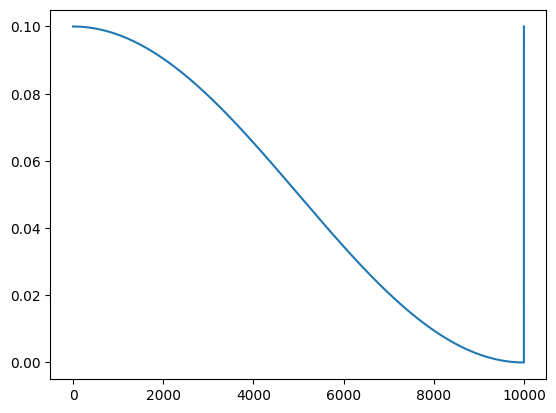

In [12]:
plt.plot(all_lrs)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import pickle
import torch
import os
import copy
import torch.nn as nn
import seaborn as sns


/home/zsarwar/.conda/envs/cnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
MSELoss_none = nn.MSELoss(reduction='none')
MSELoss = nn.MSELoss(reduction='mean')
flatten = nn.Flatten()

In [8]:
x = torch.randn(size=(2,3,3))
y = torch.randn(size=(2,3,3))

In [9]:
res = MSELoss_none(flatten(x), flatten(y))


In [11]:
res

tensor([[2.5098e+00, 4.4126e-01, 6.7861e-02, 2.5196e+00, 2.1708e-02, 2.4271e-01,
         8.1274e-02, 8.7105e-02, 1.0496e+00],
        [1.3705e+00, 2.6457e-04, 5.9851e-01, 1.2695e+00, 1.2045e+00, 9.4492e+00,
         4.3378e-01, 1.7248e+00, 3.5298e+00]])

In [12]:
res = torch.sqrt(res)

In [15]:
res.max(dim=1)[0]

tensor([1.5873, 3.0740])

In [16]:
res

tensor([[1.5842, 0.6643, 0.2605, 1.5873, 0.1473, 0.4927, 0.2851, 0.2951, 1.0245],
        [1.1707, 0.0163, 0.7736, 1.1267, 1.0975, 3.0740, 0.6586, 1.3133, 1.8788]])

In [38]:
res = MSELoss_none(x,y)
res

tensor([[[8.4204e-05, 5.0345e+00, 2.0480e+00],
         [3.8545e+00, 5.1110e-01, 1.1981e+00],
         [4.1183e+00, 3.0365e-02, 6.0268e-04]],

        [[2.3080e+00, 3.7315e+00, 1.0827e-01],
         [2.1317e-03, 6.2068e-04, 8.5988e-04],
         [2.6596e-03, 2.4393e-01, 7.5075e-01]]])